In [1]:
!pip install GEOparse scikit-learn seaborn matplotlib pandas numpy

import GEOparse
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Download dataset
gse = GEOparse.get_GEO(geo="GSE20685", destdir="./data")

16-Oct-2025 17:09:18 DEBUG utils - Directory ./data already exists. Skipping.
16-Oct-2025 17:09:18 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE20nnn/GSE20685/soft/GSE20685_family.soft.gz to ./data/GSE20685_family.soft.gz
100%|████████████████████████████████████████| 203M/203M [01:13<00:00, 2.89MB/s]
16-Oct-2025 17:10:34 DEBUG downloader - Size validation passed
16-Oct-2025 17:10:34 DEBUG downloader - Moving /var/folders/jb/tm9nnps15vq9957p_1j8265h0000gn/T/tmpuq4mz73d to /Users/dishajain/Downloads/p_demo/data/GSE20685_family.soft.gz
16-Oct-2025 17:10:34 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE20nnn/GSE20685/soft/GSE20685_family.soft.gz
16-Oct-2025 17:10:34 INFO GEOparse - Parsing ./data/GSE20685_family.soft.gz: 
16-Oct-2025 17:10:34 DEBUG GEOparse - DATABASE: GeoMiame
16-Oct-2025 17:10:34 DEBUG GEOparse - SERIES: GSE20685
16-Oct-2025 17:10:34 DEBUG GEOparse - PLATFORM: GPL570
16-Oct-2025 17:10:36 DEBUG GEOparse - SAMP

In [3]:
# Extract expression matrix and metadata
exprs_data = gse.pivot_samples("VALUE")
metadata = gse.phenotype_data

In [4]:
print("Expression shape:", exprs_data.shape)
print("Metadata shape:", metadata.shape)

Expression shape: (54627, 327)
Metadata shape: (327, 61)


In [5]:
print("STEP 2: MERGING EXPRESSION AND CLINICAL LABELS")
print("="*50)

# Use event_death as the primary outcome
# Convert to numeric and handle missing values
metadata['death_event'] = pd.to_numeric(metadata['characteristics_ch1.3.event_death'], errors='coerce')

# Check the distribution of death events
print("Death Event Distribution:")
print(metadata['death_event'].value_counts(dropna=False))
print()

# Drop rows with missing death event labels
metadata_clean = metadata.dropna(subset=['death_event'])

# Match samples between expression and metadata
common_samples = list(set(exprs_data.columns) & set(metadata_clean.index))
exprs_filtered = exprs_data[common_samples]
labels = metadata_clean.loc[common_samples, 'death_event'].astype(int)

# Transpose for easier handling (samples as rows, genes as columns)
X = exprs_filtered.T
y = labels

print("Final dataset shape (samples x features):", X.shape)
print("Label distribution:")
print(y.value_counts())
print()

STEP 2: MERGING EXPRESSION AND CLINICAL LABELS
Death Event Distribution:
death_event
0    244
1     83
Name: count, dtype: int64

Final dataset shape (samples x features): (327, 54627)
Label distribution:
death_event
0    244
1     83
Name: count, dtype: int64



Missing Values in Expression Data:
Total missing values: 0
Samples with missing values: 0
Genes with missing values: 0



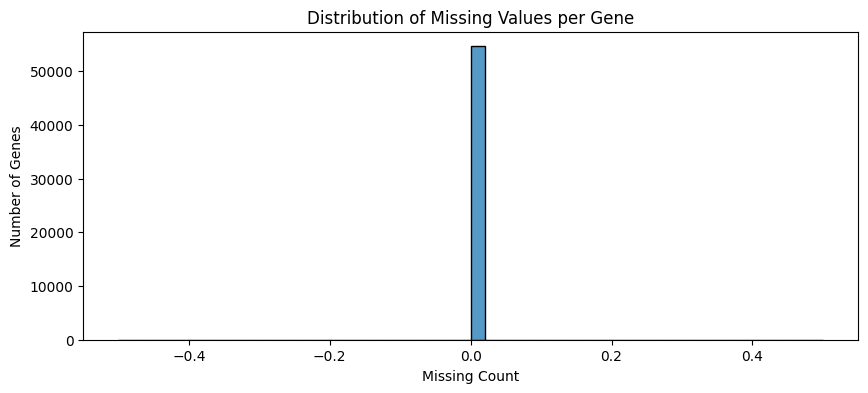

Variance Filtering:
Mean variance: 0.9786
Median variance: 0.7097
Min variance: 0.0032
Max variance: 15.5786


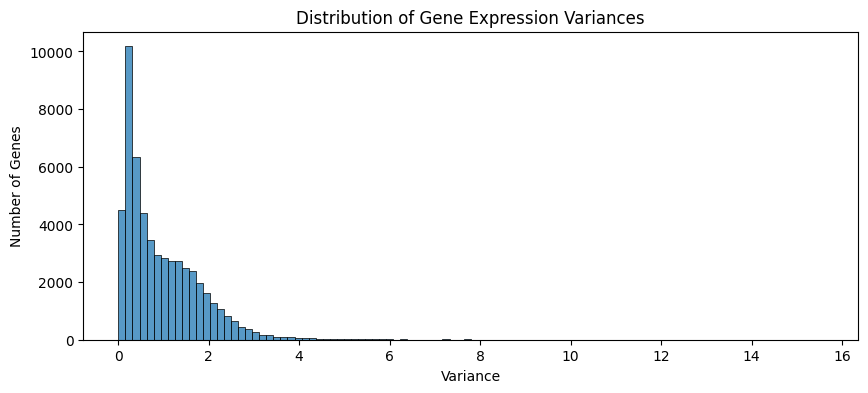

After variance filtering (threshold=0.01): (327, 54616)

Normalization:
Normalized data shape: (327, 54616)



In [6]:
# Missing Values Check
print("Missing Values in Expression Data:")
missing_per_sample = X.isnull().sum(axis=1)
missing_per_gene = X.isnull().sum(axis=0)

print(f"Total missing values: {X.isnull().sum().sum()}")
print(f"Samples with missing values: {missing_per_sample[missing_per_sample > 0].shape[0]}")
print(f"Genes with missing values: {missing_per_gene[missing_per_gene > 0].shape[0]}")
print()

# Plot distribution of missing values per gene
plt.figure(figsize=(10, 4))
sns.histplot(missing_per_gene, bins=50)
plt.title("Distribution of Missing Values per Gene")
plt.xlabel("Missing Count")
plt.ylabel("Number of Genes")
plt.savefig("missing_values_per_gene.png")
plt.show()

# Variance Filtering
print("Variance Filtering:")
from sklearn.feature_selection import VarianceThreshold

# Check variance distribution
variances = X.var()
print(f"Mean variance: {variances.mean():.4f}")
print(f"Median variance: {variances.median():.4f}")
print(f"Min variance: {variances.min():.4f}")
print(f"Max variance: {variances.max():.4f}")

# Plot variance distribution
plt.figure(figsize=(10, 4))
sns.histplot(variances, bins=100)
plt.title("Distribution of Gene Expression Variances")
plt.xlabel("Variance")
plt.ylabel("Number of Genes")
plt.savefig("gene_expression_variances.png")
plt.show()

# Apply variance threshold
var_thresh = VarianceThreshold(threshold=0.01)
X_var_filtered = var_thresh.fit_transform(X)

print(f"After variance filtering (threshold=0.01): {X_var_filtered.shape}")
print()

# Normalization (Z-score)
print("Normalization:")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_var_filtered)

# Convert back to DataFrame for easier handling
selected_indices = var_thresh.get_support(indices=True)
genes_selected = X.columns[selected_indices]
X_scaled_df = pd.DataFrame(X_scaled, columns=genes_selected, index=X.index)

print("Normalized data shape:", X_scaled_df.shape)
print()

In [7]:
# Top 1000 Most Variable Genes
print("Selecting top 1000 most variable genes...")
selector = SelectKBest(score_func=f_classif, k=1000)
X_selected = selector.fit_transform(X_scaled, y)
selected_indices_final = selector.get_support(indices=True)

genes_final = X_scaled_df.columns[selected_indices_final]

# Final dataset
X_final = pd.DataFrame(X_selected, columns=genes_final, index=X.index)
y_final = y.reset_index(drop=True)

print("Final Features Shape:", X_final.shape)
print()

# Check class balance
print("Class Balance in Final Dataset:")
print(y_final.value_counts())
print(f"Class 0 proportion: {sum(y_final==0)/len(y_final):.3f}")
print(f"Class 1 proportion: {sum(y_final==1)/len(y_final):.3f}")
print()

Selecting top 1000 most variable genes...
Final Features Shape: (327, 1000)

Class Balance in Final Dataset:
death_event
0    244
1     83
Name: count, dtype: int64
Class 0 proportion: 0.746
Class 1 proportion: 0.254



In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final,
    test_size=0.2,
    stratify=y_final,
    random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training label distribution:")
print(y_train.value_counts())
print("Test label distribution:")
print(y_test.value_counts())
print()

# Step 6: Model Training
print("="*50)
print("STEP 6: MODEL TRAINING & EVALUATION")
print("="*50)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model Definitions
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Train and evaluate models
results = {}
model_objects = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Cross-validation
    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv)
    results[name] = scores
    print(f"{name} - Mean AUC: {np.mean(scores):.3f} (+/- {np.std(scores)*2:.3f})")

    # Train final model
    model.fit(X_train, y_train)
    model_objects[name] = model

# Display results
results_df = pd.DataFrame(results)
print("\nCross-validation AUC Scores:")
print(results_df.describe())
print()

Training set shape: (261, 1000)
Test set shape: (66, 1000)
Training label distribution:
death_event
0    195
1     66
Name: count, dtype: int64
Test label distribution:
death_event
0    49
1    17
Name: count, dtype: int64

STEP 6: MODEL TRAINING & EVALUATION

Training Logistic Regression...
Logistic Regression - Mean AUC: 0.940 (+/- 0.047)

Training Random Forest...
Random Forest - Mean AUC: 0.794 (+/- 0.098)

Training SVM...
SVM - Mean AUC: 0.869 (+/- 0.044)

Cross-validation AUC Scores:
       Logistic Regression  Random Forest       SVM
count             5.000000       5.000000  5.000000
mean              0.939589       0.794196  0.869343
std               0.026154       0.054757  0.024695
min               0.897436       0.737673  0.850099
25%               0.930966       0.738659  0.854043
50%               0.952381       0.800366  0.856016
75%               0.958580       0.841223  0.877289
max               0.958580       0.853057  0.909270

